# Bank Customer Churn Prediction

# Libraries Used

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.metrics import classification_report

from imblearn.under_sampling import RandomUnderSampler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier


# DataSet Details

In [4]:
df = pd.read_csv(r"dataset\botswana_bank_customer_churn.csv")
pd.set_option("display.max_columns",False)
df

,RowNumber,CustomerId,Surname,First Name,Date of Birth,Gender,Marital Status,Number of Dependents,Occupation,Income,Education Level,Address,Contact Information,Customer Tenure,Customer Segment,Preferred Communication Channel,Credit Score,Credit History Length,Outstanding Loans,Churn Flag,Churn Reason,Churn Date,Balance,NumOfProducts,NumComplaints
0,1,83ef0b54-35f6-4f84-af58-5653ac0c0dc4,Smith,Troy,1987-08-29,Male,Divorced,3,Information systems manager,77710.14,High School,"26644 Diaz Viaduct\nNorth Jessicaville, VI 14852",001-301-934-3058x0825,30,Retail,Phone,397,24,41959.74,0,NaN,NaN,211359.05,1,0
1,2,009f115a-e5ca-4cf4-97d6-530140545e4e,Sullivan,Katrina,2000-02-07,Female,Married,1,Charity fundraiser,58209.87,High School,"5642 Rachel Pass Suite 320\nPort Peggy, RI 75805",+1-581-683-4267,27,SME,Email,665,10,8916.67,0,NaN,NaN,30624.76,4,1
2,3,66309fd3-5009-44d3-a3f7-1657c869d573,Fuller,Henry,1954-02-03,Female,Single,1,Television production assistant,9794.01,High School,00025 Brittany Flats Apt. 543\nNew Amandaborou...,9753900004,14,Retail,Email,715,21,43270.54,0,NaN,NaN,111956.61,2,6
3,4,b02a30df-1a5f-4087-8075-2a35432da641,Young,Antonio,1991-01-15,Female,Divorced,5,Agricultural engineer,15088.98,High School,Unit 3386 Box 0088\nDPO AE 71940,+1-928-477-2856x660,23,Corporate,Phone,747,17,17887.65,0,NaN,NaN,201187.61,1,0
4,5,0d932e5b-bb3a-4104-8c83-f84270f7f2ea,Andersen,John,1992-04-08,Female,Divorced,2,"Teacher, early years/pre",60726.56,Master's,"0120 Leslie River\nWest Lindseychester, MN 98290",204.515.2388,22,Corporate,Email,549,25,32686.84,0,NaN,NaN,60391.24,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115635,115636,b4ef7eba-1a9e-4956-b827-50037a1087d5,Russell,Gregory,1965-03-09,Male,Divorced,2,Chemical engineer,15704.15,Diploma,"582 Davis Club Apt. 511\nScottview, MS 82178",001-382-802-1191x6905,10,Corporate,Phone,350,23,26370.30,1,Account Closure,2024-06-24,20804.19,2,7
115636,115637,578e6b99-b42a-4af1-afb4-fd570ea0721f,Ramirez,Thomas,1955-01-10,Female,Single,3,Chartered legal executive (England and Wales),75792.62,High School,"6372 Moore Lights Apt. 690\nSouth Benjamin, OH...",+1-894-758-0762x9444,8,Corporate,Email,721,15,36229.64,0,NaN,NaN,10041.21,4,7
115637,115638,73a64c22-da8f-4c3e-8f62-d92f03636a1e,Clark,Tonya,1955-08-29,Male,Married,4,Field trials officer,30142.28,Diploma,"4952 Thomas Corners Apt. 346\nEdwinshire, GU 4...",(734)940-1024,28,Retail,Email,773,19,6440.85,0,NaN,NaN,108833.43,1,4
115638,115639,00affc66-75c4-43c4-9019-f28c434b5012,Stewart,Lisa,1992-12-27,Female,Married,0,Legal secretary,58636.06,High School,"9575 Edward Springs\nMichaelmouth, KS 02190",(980)271-6580,22,Retail,Phone,584,23,5740.08,0,NaN,NaN,195548.32,5,6


* 115640 Records and 25 Columns
* Not All Columns are Required for Prediction

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115640 entries, 0 to 115639
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   RowNumber                        115640 non-null  int64  
 1   CustomerId                       115640 non-null  object 
 2   Surname                          115640 non-null  object 
 3   First Name                       115640 non-null  object 
 4   Date of Birth                    115640 non-null  object 
 5   Gender                           115640 non-null  object 
 6   Marital Status                   115640 non-null  object 
 7   Number of Dependents             115640 non-null  int64  
 8   Occupation                       115640 non-null  object 
 9   Income                           115640 non-null  float64
 10  Education Level                  115640 non-null  object 
 11  Address                          115640 non-null  object 
 12  Co

* Type Conversion Needed for Date of Birth

In [71]:
df["Date of Birth"] = pd.to_datetime(df["Date of Birth"])

* Age Calculation

In [72]:
df["Age"] = (pd.Timestamp.today()-df["Date of Birth"]).dt.days//365

# New DataSet (with Required Columns)

In [73]:
df_new = df[['Gender','Age','Education Level','Marital Status','Number of Dependents','Income','Customer Tenure','Preferred Communication Channel','Credit Score','Credit History Length','Outstanding Loans','Balance','Churn Flag']]

* Renaming Column Names for Easy Access

In [74]:
df_new = df_new.rename(columns={"Education Level":"Education","Marital Status":"Marital_Status","Number of Dependents":"Dependents","Customer Tenure":"Tenure","Preferred Communication Channel":"Communication_Preference","Credit Score":"Credit_Score","Credit History Length":"Credit_History_Length","Outstanding Loans":"Outstanding_Loans","Churn Flag":"Churn_Flag"})

* New DataSet

In [75]:
df_new.head()

,Gender,Age,Education,Marital_Status,Dependents,Income,Tenure,Communication_Preference,Credit_Score,Credit_History_Length,Outstanding_Loans,Balance,Churn_Flag
0,Male,37,High School,Divorced,3,77710.14,30,Phone,397,24,41959.74,211359.05,0
1,Female,25,High School,Married,1,58209.87,27,Email,665,10,8916.67,30624.76,0
2,Female,71,High School,Single,1,9794.01,14,Email,715,21,43270.54,111956.61,0
3,Female,34,High School,Divorced,5,15088.98,23,Phone,747,17,17887.65,201187.61,0
4,Female,32,Master's,Divorced,2,60726.56,22,Email,549,25,32686.84,60391.24,0


* Null Values Check

In [76]:
df_new.isna().sum()

Gender                      0
Age                         0
Education                   0
Marital_Status              0
Dependents                  0
Income                      0
Tenure                      0
Communication_Preference    0
Credit_Score                0
Credit_History_Length       0
Outstanding_Loans           0
Balance                     0
Churn_Flag                  0
dtype: int64

* Unique Values

In [77]:
for i in df_new:
    if df_new[i].dtypes == "object":
        print(df_new[i].value_counts())
        print()

Gender
Female    57830
Male      57810
Name: count, dtype: int64

Education
Master's       28970
Diploma        28950
High School    28868
Bachelor's     28852
Name: count, dtype: int64

Marital_Status
Single      38684
Divorced    38539
Married     38417
Name: count, dtype: int64

Communication_Preference
Email    58044
Phone    57596
Name: count, dtype: int64



# Encoded DataSet

In [78]:
df_encoded = df_new.copy()

* Label & Ordinal Encoding

In [79]:
le_gender = LabelEncoder()
df_encoded["Gender"] = le_gender.fit_transform(df_encoded["Gender"])

le_communication = LabelEncoder()
df_encoded["Communication_Preference"] = le_gender.fit_transform(df_encoded["Communication_Preference"])

oe_education = OrdinalEncoder(categories=[["High School","Diploma","Bachelor's","Master's"]])
df_encoded["Education"] = oe_education.fit_transform(df_encoded[["Education"]])

oe_marital_status = OrdinalEncoder(categories=[["Single","Married","Divorced"]])
df_encoded["Marital_Status"] = oe_marital_status.fit_transform(df_encoded[["Marital_Status"]])

* Type Conversion (float to int)

In [80]:
df_encoded = df_encoded.astype(int)
df_encoded.head()

,Gender,Age,Education,Marital_Status,Dependents,Income,Tenure,Communication_Preference,Credit_Score,Credit_History_Length,Outstanding_Loans,Balance,Churn_Flag
0,1,37,0,2,3,77710,30,1,397,24,41959,211359,0
1,0,25,0,1,1,58209,27,0,665,10,8916,30624,0
2,0,71,0,0,1,9794,14,0,715,21,43270,111956,0
3,0,34,0,2,5,15088,23,1,747,17,17887,201187,0
4,0,32,3,2,2,60726,22,0,549,25,32686,60391,0


* Correlation with Label Columns 

In [81]:
df_encoded.corr(numeric_only=True)["Churn_Flag"]

Gender                      0.001280
Age                        -0.002504
Education                   0.002939
Marital_Status              0.003774
Dependents                  0.003109
Income                      0.002286
Tenure                      0.000344
Communication_Preference    0.000069
Credit_Score               -0.182802
Credit_History_Length       0.002899
Outstanding_Loans          -0.001146
Balance                    -0.499981
Churn_Flag                  1.000000
Name: Churn_Flag, dtype: float64

* Correlation of Columns

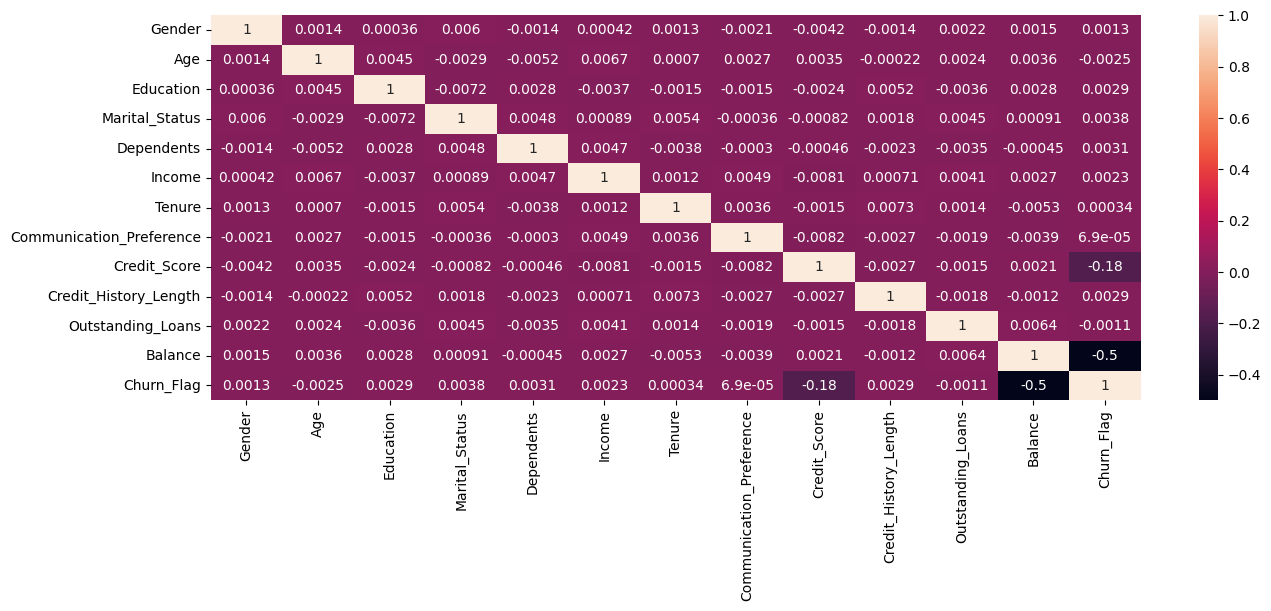

In [82]:
plt.figure(figsize=(15,5))
sns.heatmap(df_encoded.corr(numeric_only=True),annot=True)
plt.show()

# Outlier Detection

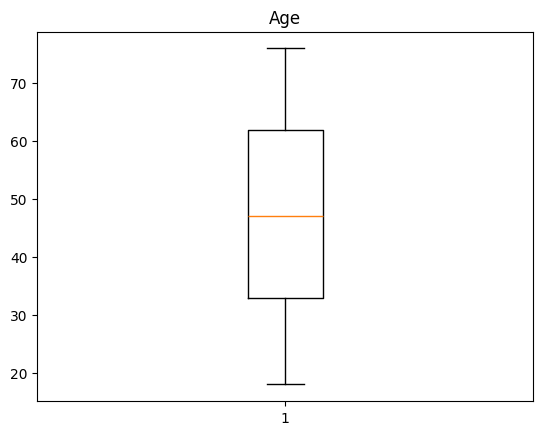

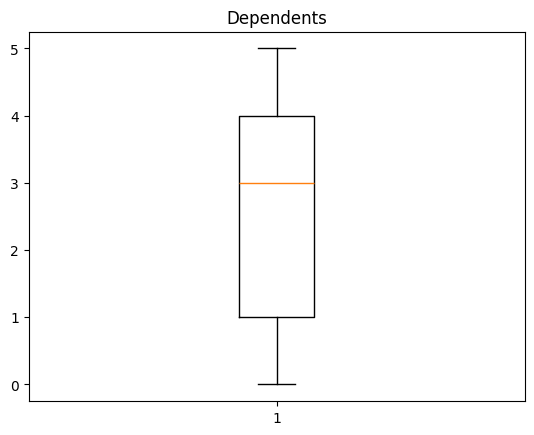

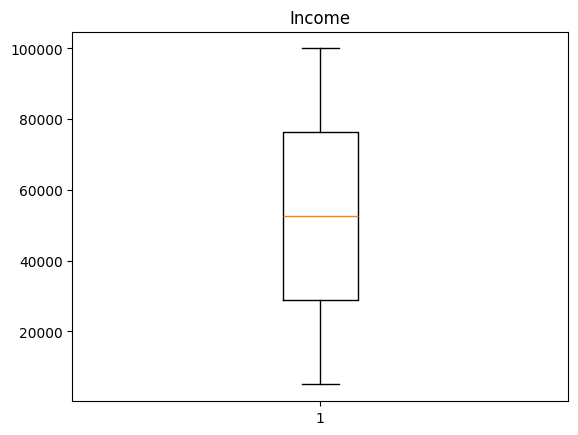

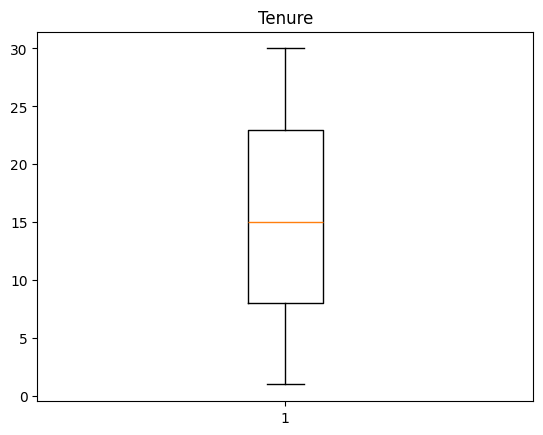

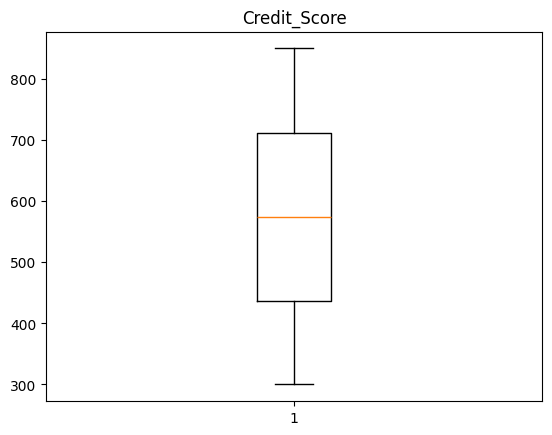

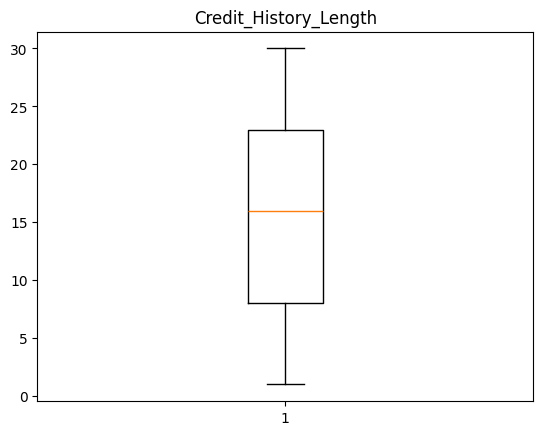

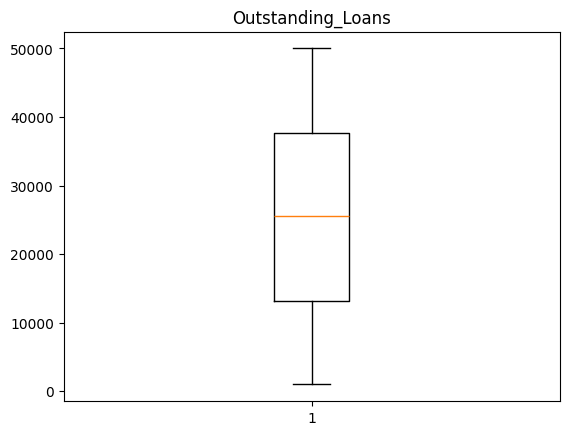

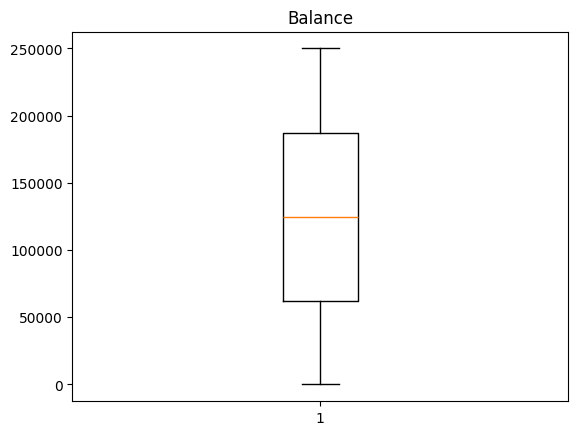

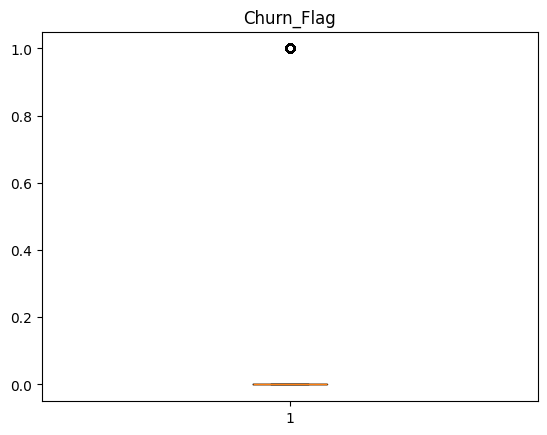

In [84]:
for i in df_new:
    if df_new[i].dtypes == "int" or df_new[i].dtypes == "float":
        plt.title(i)
        plt.boxplot(df_new[i])
        plt.show()

*  No Outliers Detected

# X & Y

In [85]:
x = df_encoded.drop(columns=["Churn_Flag"])
y = df_encoded["Churn_Flag"]

* Scaling "x" values

In [86]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Under Sampling

In [87]:
y.value_counts()

Churn_Flag
0    101546
1     14094
Name: count, dtype: int64

* Under Sampling "y"

In [88]:
rus = RandomUnderSampler()
x_res,y_res = rus.fit_resample(x_scaled,y)
y_res.value_counts()

Churn_Flag
0    14094
1    14094
Name: count, dtype: int64

# Train Test Split

In [89]:
x_train,x_test,y_train,y_test = train_test_split(x_res,y_res,test_size=0.3,random_state=3)

In [90]:
models = [KNeighborsClassifier(),SVC(),GaussianNB(),DecisionTreeClassifier()]

for i in models:
    print(i)
    i.fit(x_train,y_train)
    y_pred = i.predict(x_test)
    print(classification_report(y_test,y_pred))
    print(cross_val_score(i,x_train,y_train).mean())
    print()

KNeighborsClassifier()
              precision    recall  f1-score   support

           0       0.91      0.77      0.84      4226
           1       0.80      0.93      0.86      4231

    accuracy                           0.85      8457
   macro avg       0.86      0.85      0.85      8457
weighted avg       0.86      0.85      0.85      8457

0.844103299278029

SVC()
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      4226
           1       0.86      0.95      0.91      4231

    accuracy                           0.90      8457
   macro avg       0.90      0.90      0.90      8457
weighted avg       0.90      0.90      0.90      8457

0.9001065563213337

GaussianNB()
              precision    recall  f1-score   support

           0       0.95      0.83      0.89      4226
           1       0.85      0.95      0.90      4231

    accuracy                           0.89      8457
   macro avg       0.90      0.89      0.89    

* SVM Model Gives more Accuracy i.e 90%

# SVM Model

In [91]:
svc = SVC()
svc.fit(x_train,y_train)
y_pred = svc.predict(x_test)

print(classification_report(y_test,y_pred))
print(cross_val_score(svc,x_train,y_train).mean())

              precision    recall  f1-score   support

           0       0.95      0.85      0.90      4226
           1       0.86      0.95      0.91      4231

    accuracy                           0.90      8457
   macro avg       0.90      0.90      0.90      8457
weighted avg       0.90      0.90      0.90      8457

0.9001065563213337


* SVM gives out a Cross Validation Score of 90%

# HyperParameter Tuning

In [ ]:
params = {'C':[0.1,1,10],'kernel':['linear','rbf'],'gamma':['scale','auto',0.01,0.1],'degree':[2,3],'coef0':[0.0,0.1],'shrinking':[True,False]}

random_search = RandomizedSearchCV(svc,params,cv=5,scoring='accuracy')
random_search.fit(x_train, y_train)

print("Best Estimators:", random_search.best_estimator_)
print("Best Score:", random_search.best_score_)

Best Estimators: SVC(C=0.1, degree=2, kernel='linear')
Best Score: 0.9048201133339095


In [93]:
svc = SVC(C=1, degree=2, kernel='linear')
svc.fit(x_train,y_train)
y_pred = svc.predict(x_test)

print(classification_report(y_test,y_pred))
print(cross_val_score(svc,x_train,y_train).mean())

              precision    recall  f1-score   support

           0       0.95      0.86      0.90      4226
           1       0.87      0.95      0.91      4231

    accuracy                           0.90      8457
   macro avg       0.91      0.90      0.90      8457
weighted avg       0.91      0.90      0.90      8457

0.9046174020675112


# Pickle

In [94]:
# dit = {"Model":svc,"Scaler":scaler,"Gender":le_gender,"Education":oe_education,"Marriage":oe_marital_status,"Communicate":le_communication}

# with open("Bank_Churn.pkl","wb") as f:
#     pickle.dump(dit,f)